In [5]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import ast

In [6]:
# Load data
train_data = pd.read_csv('data/raw/train.csv')
test_data = pd.read_csv('data/raw/test.csv')

# Ensure connections are lists
train_data['Connections'] = train_data['Connections'].apply(ast.literal_eval)
test_data['Connections'] = test_data['Connections'].apply(ast.literal_eval)

In [7]:
# Create a mapping from ID to index
all_ids = pd.concat([train_data['ID'], test_data['ID']]).unique()
id_to_index = {id: idx for idx, id in enumerate(all_ids)}

# Convert IDs to indices
train_data['Index'] = train_data['ID'].map(id_to_index)
test_data['Index'] = test_data['ID'].map(id_to_index)

# Convert connections to index-based
train_data['Connections'] = train_data['Connections'].apply(lambda x: [id_to_index[neighbor] for neighbor in x])
test_data['Connections'] = test_data['Connections'].apply(lambda x: [id_to_index[neighbor] for neighbor in x])

In [8]:
# Create a sparse adjacency matrix for the entire dataset
row_indices = []
col_indices = []
for idx, row in pd.concat([train_data, test_data]).iterrows():
    for neighbor in row['Connections']:
        row_indices.append(id_to_index[row['ID']])
        col_indices.append(neighbor)

In [9]:
adjacency_matrix = csr_matrix((np.ones(len(row_indices)), (row_indices, col_indices)), shape=(len(all_ids), len(all_ids)))

In [13]:
def compute_neighbor_features(data_subset, adjacency_matrix, age_array):
    indices = data_subset['Index'].values
    num_neighbors = adjacency_matrix[indices].sum(axis=1).A1
    avg_age_neighbors = adjacency_matrix[indices].dot(age_array) / np.maximum(num_neighbors, 1)
    return num_neighbors, avg_age_neighbors

In [16]:
# Infected and age arrays for the entire dataset
age_array = np.zeros(len(all_ids))
age_array[train_data['Index']] = train_data['Age']

In [17]:
# Compute neighbor features for train data
train_data['num_neighbors'], train_data['avg_age_neighbors'] = compute_neighbor_features(train_data, adjacency_matrix, age_array)

In [19]:
# Normalize features
scaler = StandardScaler()
train_data[['Age', 'Constitution', 'num_neighbors', 'avg_age_neighbors']] = scaler.fit_transform(train_data[['Age', 'Constitution', 'num_neighbors', 'avg_age_neighbors']])

In [20]:
train_data['Behaviour'] = train_data['Behaviour'].map({0: 0, 1: 1, 2: 2})

In [22]:
# Split data
X = train_data[['Age', 'Constitution', 'Behaviour', 'num_neighbors', 'avg_age_neighbors']]
y = train_data['Infected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Train model
# model = LogisticRegression()
# model.fit(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.57      0.55    103536
           1       0.47      0.43      0.45     91464

    accuracy                           0.51    195000
   macro avg       0.50      0.50      0.50    195000
weighted avg       0.50      0.51      0.50    195000



AUC: 0.503760893596278


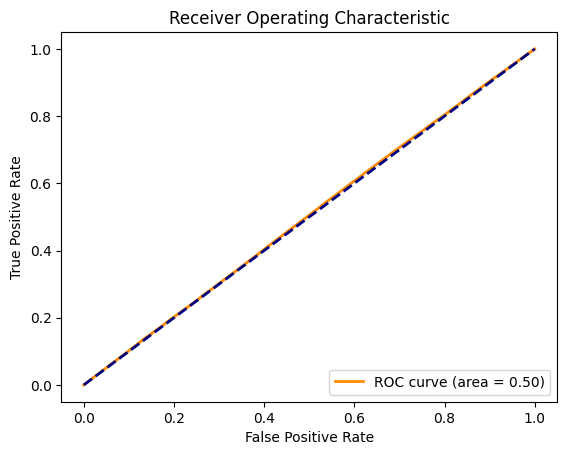

In [31]:
# Probabilistic outputs
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.54      0.91      0.68    103536
           1       0.51      0.10      0.17     91464

    accuracy                           0.53    195000
   macro avg       0.52      0.51      0.42    195000
weighted avg       0.53      0.53      0.44    195000

AUC: 0.5203762319304972


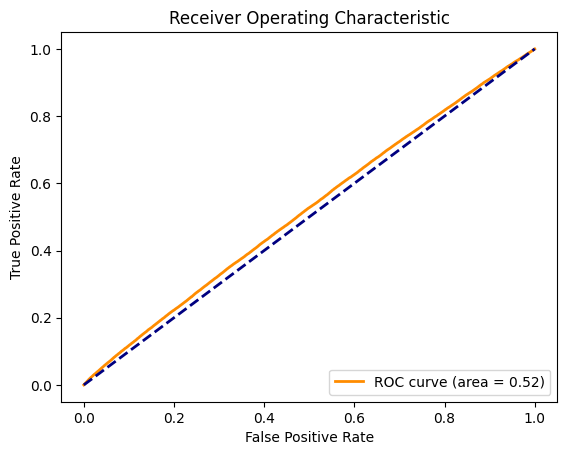

In [28]:
# Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC Curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()